# Substituindo Grid/Randomized Search por um método mais eficiente.

https://github.com/scikit-optimize

In [1]:
!pip install scikit-optimize

In [3]:
# Find the minimum of the noisy function f(x) over the range -2 < x < 2 with skopt:
import numpy as np
from skopt import gp_minimize

def f(x):
    return (np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) +
            np.random.randn() * 0.1)

res = gp_minimize(f, [(-2.0, 2.0)])

In [2]:
# For more control over the optimization loop you can use the skopt.Optimizer class:

from skopt import Optimizer

opt = Optimizer([(-2.0, 2.0)])

for i in range(20):
    suggested = opt.ask()
    y = f(suggested)
    opt.tell(suggested, y)
    print('iteration:', i, suggested, y)

iteration: 0 [-1.9619418474224668] -0.05195140777591529
iteration: 1 [-1.9402870371472134] 0.0199616008488165
iteration: 2 [-0.40438608219079253] -0.8679593181804641
iteration: 3 [-1.3030847911452197] 0.22474188657213737
iteration: 4 [-1.9756820497061702] 0.12517070566227276
iteration: 5 [1.3425176565131673] -0.0664723247512396
iteration: 6 [-1.905718681312504] -0.11069025568740429
iteration: 7 [-1.8310962707621297] -0.10454215485088925
iteration: 8 [0.1546435679157514] 0.7677726470131438
iteration: 9 [-1.952515279846447] -0.04644632479212655
iteration: 10 [-0.4367722408069852] -0.5524596644920876
iteration: 11 [-0.3602622503159536] -1.0402482194272435
iteration: 12 [-0.3376007138719148] -0.954257065839853
iteration: 13 [-0.22555850153722634] -0.7780801055923685
iteration: 14 [2.0] -0.051068195306905075
iteration: 15 [-0.3239864356889606] -0.7420848953795081
iteration: 16 [-0.3695560321804936] -0.6265070774509356
iteration: 17 [0.8547017067648541] -0.42677486485009214
iteration: 18 [-0

In [5]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

<Figure size 432x288 with 0 Axes>

In [6]:
from skopt.benchmarks import branin as branin
from skopt.benchmarks import hart6 as hart6_


# redefined `hart6` to allow adding arbitrary "noise" dimensions
def hart6(x):
    return hart6_(x[:6])

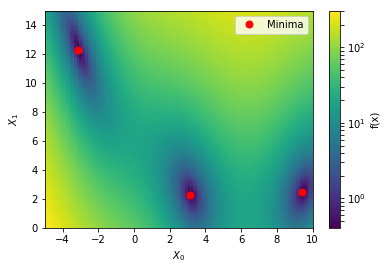

In [7]:
from matplotlib.colors import LogNorm

def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])

plot_branin()

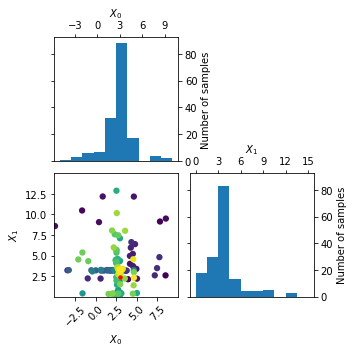

In [5]:
from functools import partial
from skopt.plots import plot_evaluations
from skopt import gp_minimize, forest_minimize, dummy_minimize


bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 160

forest_res = forest_minimize(branin, bounds, n_calls=n_calls, base_estimator="ET",
                             random_state=4)

_ = plot_evaluations(forest_res, bins=10)

# Minimal example
A minimal example of optimizing hyperparameters of SVC (Support Vector machine Classifier) is given below.

In [8]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(10, True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

C:\Users\sn3fru\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


val. score: 0.9851521900519673
test score: 0.9844444444444445


In [9]:
opt.best_params_

{'C': 0.005671730067319851,
 'degree': 2,
 'gamma': 0.0059768107607451005,
 'kernel': 'poly'}

# Advanced example
In practice, one wants to enumerate over multiple predictive model classes, with different search spaces and number of evaluations per class. An example of such search over parameters of Linear SVM, Kernel SVM, and decision trees is given below.

In [7]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X, y = load_digits(10, True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# pipeline class is used as estimator to enable 
# search over different model types
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is 
# sets the model class
linsvc_search = {
    'model': [LinearSVC(max_iter=10000)],
    'model__C': (1e-6, 1e+6, 'log-uniform'),
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    [(svc_search, 20), (linsvc_search, 16)], # (parameter space, # of evaluations)
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9851521900519673
test score: 0.9822222222222222


# Progress monitoring and control using callback argument of fit method
It is possible to monitor the progress of BayesSearchCV with an event handler that is called on every step of subspace exploration. For single job mode, this is called on every evaluation of model configuration, and for parallel mode, this is called when n_jobs model configurations are evaluated in parallel.

Additionally, exploration can be stopped if the callback returns True. This can be used to stop the exploration early, for instance when the accuracy that you get is sufficiently high.

An example usage is shown below.

In [10]:
from skopt import BayesSearchCV

from sklearn.datasets import load_iris
from sklearn.svm import SVC

X, y = load_iris(True)

searchcv = BayesSearchCV(
    SVC(),
    search_spaces={'C': (0.01, 100.0, 'log-uniform')},
    n_iter=10
)


# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True


searchcv.fit(X, y, callback=on_step)

best score: 0.9333333333333333
best score: 0.9733333333333334
best score: 0.9733333333333334
best score: 0.9733333333333334
best score: 0.9733333333333334
best score: 0.9733333333333334
best score: 0.9733333333333334
best score: 0.9733333333333334
best score: 0.9733333333333334
best score: 0.9733333333333334


BayesSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_iter=10, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'C': (0.01, 100.0, 'log-uniform')}, verbose=0)

# Counting total iterations that will be used to explore all subspaces
Subspaces in previous examples can further increase in complexity if you add new model subspaces or dimensions for feature extraction pipelines. For monitoring of progress, you would like to know the total number of iterations it will take to explore all subspaces. This can be calculated with total_iterations property, as in the code below.

In [11]:
from skopt import BayesSearchCV

from sklearn.datasets import load_iris
from sklearn.svm import SVC

X, y = load_iris(True)

searchcv = BayesSearchCV(
    SVC(),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42
